In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from scipy import signal
from scipy import stats
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf_burg
from sklearn.cluster import KMeans
import seaborn as sns

In [2]:
io = 'photoemittor_data.xlsx'
num_classes = 2
num_files = 4
pos_list = [0,1]
# 0 = excellent
# 1 = good
# 2 = fair
# 3 = bad
data = [pd.read_excel(io, sheet_name=i, header=None).to_numpy().transpose() for i in range(num_files)]

In [3]:
def clean(tmp):
    return tmp[~np.isnan(tmp)]

def bootstrap(arr,b,n):
    if b ==0:
        return (np.std(arr)**n)/np.mean(arr), 0.0
    tmp = []
    for i in range(b):
        cho = np.random.choice(arr,len(arr))
        tmp.append((np.std(cho)**n)/np.mean(cho))
    return np.mean(tmp), np.std(tmp)

def pl(x,a,b):
    return a*np.exp(x*b)

def hurst(tmp):
    freq,pxx= signal.welch((tmp-np.mean(tmp))/np.std(tmp),fs=10)
    popt,pcov = sp.optimize.curve_fit(pl,freq,pxx)
    return (-popt[1]+1.0)/2.0

def get_metrics(mats,start,steps,b):
    hurst_list = []
    cov_list= []
    snr_list = []
    mean_list = []
    std_list = []
    for i in range(4):
        mat = mats[i]
        h = np.zeros(mat.shape[0])
        c = np.zeros_like(h)
        s = np.zeros_like(c)
        m = np.zeros_like(s)
        d= np.zeros_like(h)
        for j in range(mat.shape[0]):
            tmp = clean(mat[j])
            if steps >0:
                tmp = tmp[start:start+steps]
            h[j] = hurst(tmp)
            c[j],std = bootstrap(tmp,b,1)
            s[j],std = bootstrap(tmp,b,2)
            m[j] = np.mean(tmp)
            d[j] = np.std(tmp)
        hurst_list.append(h)
        cov_list.append(c)
        snr_list.append(s)
        mean_list.append(m)
        std_list.append(d)
    return hurst_list, cov_list,snr_list,mean_list,std_list
            

In [14]:
steps=50
cutoff=.04
b= 1000
start = 0
full_h, full_c, full_s,full_m,full_d = get_metrics(data,0,0,0)
partial_h,partial_c,partial_s,partial_m,partial_d = get_metrics(data,start,steps,b)





/home/greg/miniconda3/lib/python3.8/site-packages/scipy/signal/spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 244, using nperseg = 244
  warnings.warn('nperseg = {0:d} is greater than input length '
/home/greg/miniconda3/lib/python3.8/site-packages/scipy/signal/spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 50, using nperseg = 50
  warnings.warn('nperseg = {0:d} is greater than input length '


In [15]:
exp_label=[np.ones_like(full_h[i]) for i in range(4)]
exp_label[0] *= 0
exp_label[1] *= 1
exp_label[2] *= 2
exp_label[3] *= 3
exp_tot = np.hstack((exp_label[0],exp_label[1],exp_label[2],exp_label[3])).T

In [16]:
stacking = lambda x,y,z,w,v:np.vstack((x,y,z,w,v)).T
ease = lambda i: stacking(full_h[i],np.log(full_c[i]),np.log(full_s[i]/1000),np.log(full_m[i]/10000),np.log(full_d[i]/1000))
ex,go,fa,ba = [ease(i) for i in range(4)]
tot = np.vstack((ex,go,fa,ba))
ease = lambda i: stacking(partial_h[i],np.log(partial_c[i]),np.log(partial_s[i]/1000),np.log(partial_m[i]/10000),np.log(partial_d[i]/1000))
# print(tot)
ex,go,fa,ba = [ease(i) for i in range(4)]
part = np.vstack((ex,go,fa,ba))
# kmeans = KMeans(n_clusters=4, random_state=0).fit(tot)
# kmeans.labels_
# color_list=["red","blue","orange","cyan"]
# fig = plt.figure(figsize=(12,12))
# # ax = fig.add_subplot(projection='3d')
# ax = fig.add_subplot()
# for i in range(tot.shape[0]):
#     ax.scatter(tot[i,1],tot[i,2],color=color_list[int(exp_tot[i])])
# # plt.legend()
# plt.show()
full_data = np.append(tot,exp_tot[:,np.newaxis],axis=1)
part_data = np.append(part,exp_tot[:,np.newaxis],axis=1)
df_full = pd.DataFrame(full_data,columns=["color","coeff_var","snr","mean","std","exp_label"])
df_part = pd.DataFrame(part_data,columns=["color","coeff_var","snr","mean","std","exp_label"])

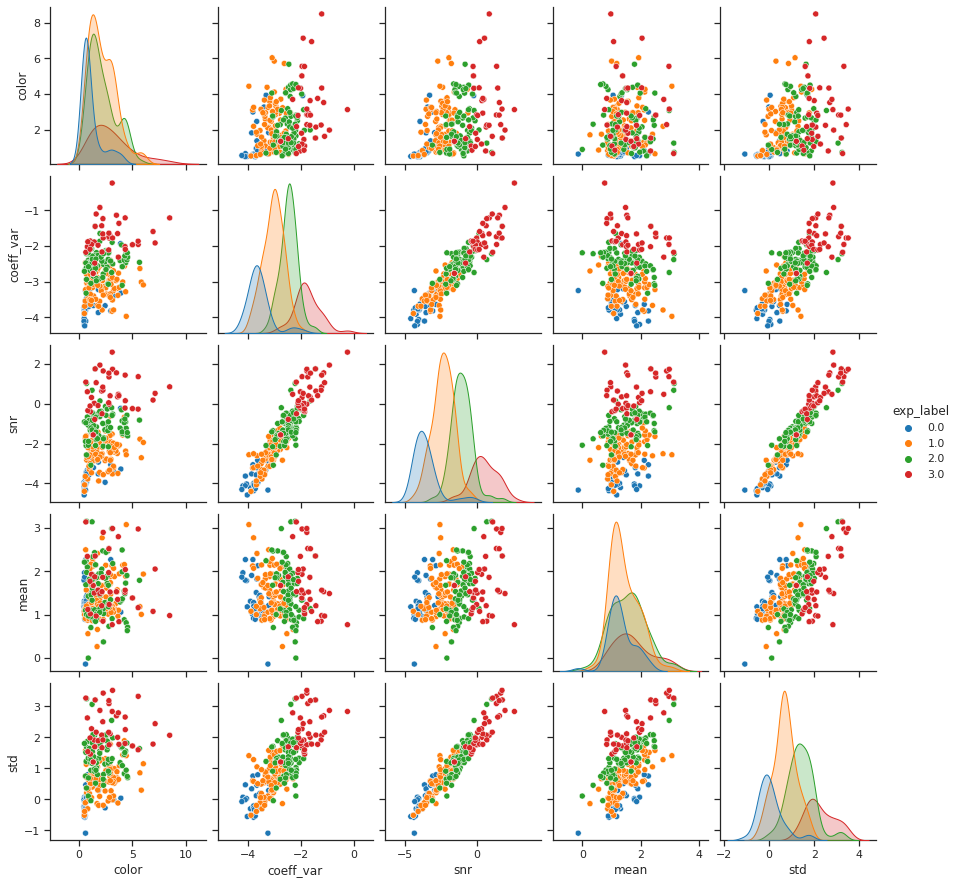

In [17]:
sns.set_theme(style="ticks")
sns.pairplot(data=df_full,hue="exp_label",palette="tab10")
# plt.savefig("pairplot.png")

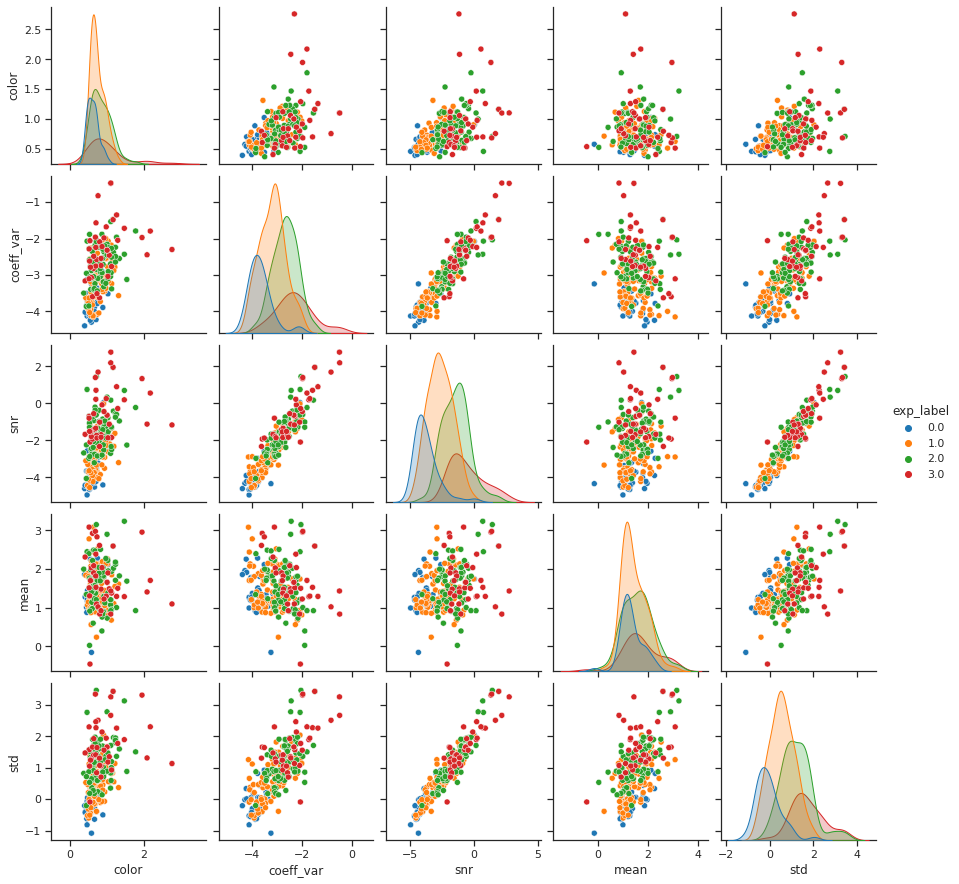

In [18]:
sns.set_theme(style="ticks")
sns.pairplot(data=df_part,hue="exp_label",palette="tab10")
# plt.savefig("pairplot.png")